# 3.2 Incompressible Navier-Stokes equations
We are solving the unsteady Navier Stokes equations:

Find $(u,p):[0,T] \to (H_{0,D}^1)^d \times L^2$, s.t.
\begin{align}
\int_{\Omega} \partial_t u \cdot v + \int_{\Omega} \nu \nabla u : \nabla v + u \cdot \nabla u\cdot v - \int_{\Omega} \operatorname{div}(v) p &= \int f v  && \forall v \in (H_{0,D}^1)^d, \\ 
- \int_{\Omega} \operatorname{div}(u) q &= 0 && \forall q \in L^2, \\
\quad u(t=0) & = u_0
\end{align}

In [1]:
# You will need Netgen/Ngsolve to run this
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry

# Standard numerical Python imports
import numpy as np
import scipy.sparse as sp
from scipy.linalg import cholesky
from scipy.sparse.linalg import svds, spsolve

# Optional, for visualization of the eigenvalues
import matplotlib.pyplot as plt

## Function for generating data

Generates FOM solutions.  Based on the official Ngsolve NSE tutorial.

In [2]:
def generate_NSE_data(h, deg, nus, tEnd, filename):

    # Def mesh geometry
    geo = SplineGeometry()
    geo.AddRectangle( (0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
    geo.AddCircle ( (0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl")
    mesh = Mesh( geo.GenerateMesh(maxh=h))
    mesh.Curve(3);

    # Def FE space and solution grid function
    V = VectorH1(mesh,order=deg, dirichlet="wall|cyl|inlet")
    Q = H1(mesh,order=deg-1)
    X = FESpace([V,Q])
    gfu = GridFunction(X)
    velocity = gfu.components[0]
    
    print(f'velocity DOFs is {V.ndofglobal}')

    # parabolic inflow at bc=1:
    uin = CoefficientFunction((1.5*4*y*(0.41-y)/(0.41*0.41),0))
    gfu.components[0].Set(uin, definedon=mesh.Boundaries("inlet"))

    (u,p), (v,q) = X.TnT()
    
    savez_dict = dict() # for storing snapshots 

    for i, nu in enumerate(nus):
        
        a = BilinearForm(X)
        stokes = (nu*InnerProduct(Grad(u)+Grad(u).trans, Grad(v))
                  -div(u)*q-div(v)*p)*dx
        a += stokes
        a.Assemble()

        f = LinearForm(X)   
        f.Assemble()

        inv_stokes = a.mat.Inverse(X.FreeDofs())

        res = f.vec.CreateVector()
        res.data = f.vec - a.mat*gfu.vec
        gfu.vec.data += inv_stokes * res

        # IMEX time discretization 

        dt = 0.00005

        # matrix for implicit part of IMEX(1) scheme:
        mstar = BilinearForm(X)
        mstar += InnerProduct(u,v)*dx + dt*stokes
        mstar.Assemble()
        inv = mstar.mat.Inverse(X.FreeDofs())

        conv = LinearForm(X)
        conv += InnerProduct(Grad(velocity)*velocity,v)*dx

        t, tend = 0, 0

        # implicit Euler/explicit Euler splitting method:
        tend += tEnd

        uh = gfu.components[0]

        ns = int(tend/dt/50) # save snapshot every 50 time steps
        snaps = np.zeros([ns, uh.vec.size])

        count, count_loc = 0, 0

        while t < tend-0.5*dt:
            print (f'nu is {nu} and t={t}', end='\r')

            conv.Assemble()
            res.data = a.mat * gfu.vec + conv.vec
            gfu.vec.data -= dt * inv * res   

            if count_loc == 49:
                snaps[count,:] = uh.vec.data
                count += 1
                count_loc = 0
            else: 
                count_loc += 1

            t = t + dt

        savez_dict['NSE_nu'+str(i)] = snaps.T
    np.savez(filename+'.npz', **savez_dict)
    
    return 'data generated'

# Class which manages the ROM

Basically all the nodal value manipulations follow from the fact that Netgen
stores its vector-valued function DOFs on top of each other in equal-sized pieces.

In [3]:
class MyROM:
    
    def __init__(self, h, deg):
        '''
        Defines mesh and FE space.  Computes mass matrix. Note that
        (h, deg) should match the data loaded in "file".
        ''' 
        # Def mesh geometry and FE space
        geo = SplineGeometry()
        geo.AddRectangle((0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
        geo.AddCircle ((0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl")
        self.mesh = Mesh(geo.GenerateMesh(maxh=h))
        self.mesh.Curve(3)
        self.V = VectorH1(self.mesh, order=deg, dirichlet="wall|cyl|inlet")
        
        # Compute mass matrix
        u, v = self.V.TnT()
        mass = BilinearForm(self.V, symmetric=True)
        mass += SymbolicBFI(InnerProduct(u, v))
        mass.Assemble()
        rows, cols, vals = mass.mat.COO()
        self.M = sp.csr_matrix((vals, (rows, cols)))
        
        
    def load_data_from_file(self, file, nSnaps):
        '''
        Loads snapshots from file and computes center component-wise.
        
        Outputs:  u -- [2n, nSnaps] array of stacked velocity components.
                  ubar -- [2n, 1] array of corresponding means.
        '''
        self.u = np.load(file, allow_pickle=True)[:,-nSnaps:]
        n = int(self.u.shape[0]/2)
        self.ubar = np.concatenate((np.mean(self.u[:n],axis=1),
                                    np.mean(self.u[n:],axis=1)),
                                   axis=0).reshape(-1,1)
        self.nSnaps = nSnaps
    
    
    def load_data_from_array(self, array, nSnaps):
        '''
        Loads snapshots from array and computes center component-wise.
        
        '''
        self.u = array[:,-nSnaps:]
        n = int(self.u.shape[0]/2)
        self.ubar = np.concatenate((np.mean(self.u[:n],axis=1),
                                    np.mean(self.u[n:],axis=1)),
                                   axis=0).reshape(-1,1)
        self.nSnaps = nSnaps
        

    def generate_POD_basis(self, numBasis=100):
        '''
        Generates POD basis from snapshot data.

        Inputs:   numBasis -- number of singular vectors to compute.

        Outputs:  POD -- [2n, numBasis] array of singular vectors.
                  ews -- length numBasis array of largest singular values 
                       in descending order.
        '''
        # Compute SVD
        R = cholesky(self.M.todense())  # wish it were sparse, but oh well
        RuTilde = R @ (self.u - self.ubar)
        U, S, _ = svds(RuTilde, k=numBasis, which='LM')

        # Because we want descending order...
        U = np.flip(U, axis=1) 
        self.ews = np.flip(S)

        # Compute POD basis
        self.POD = spsolve(R, U[:,:numBasis])
        print(f'POD basis of size {numBasis} has been generated')
        
    
    def plot_evals(self, n):
        '''
        Plots magnitude of first n eigenvalues.
        '''
        x = np.array([i+1 for i,e in enumerate(self.ews)])[:n]
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(x, self.ews[:n])
        ax.set_yscale('log')
        plt.show()
    
    
    def project(self, u, n):
        '''
        Projects full-order object to reduced space of size n.
        '''
        return self.POD[:,:n].T @ self.M @ (u - self.ubar)
        
        
    def reconstruct(self, a):
        '''
        Reconstructs full-order object from reduced-order one.
        '''
        return self.ubar + self.POD[:,:a.shape[0]] @ a
        
        
    def compute_L2_error(self, approx):
        '''
        Computes relative L2 error between snapshots and approximation.
        '''
        diff = self.u - approx
        num2 = np.trace(diff.T @ self.M @ diff)
        den2 = np.trace(self.u.T @ self.M @ self.u)
        return np.sqrt(num2/den2)
    
    
    def test_POD_projection(self):
        '''
        Tests the convergence of the computed POD basis.
        '''
        for dim in [2**i for i in range(6)]:
            # Compute % of squared EWs captured in first q_dim dimensions
            percent_energy = (np.sum(self.ews[:dim]**2) 
                              / np.sum(self.ews**2) * 100)

            # Reconstruction after projection
            aa = self.project(self.u, dim)
            projRecon = self.reconstruct(aa)

            # Relative L2 error in mass norm (no ode solve)
            error = self.compute_L2_error(projRecon)
            print(f'dim is {dim}, % energy is {percent_energy:.3f}, '
                  + f'and compression error is {error:.7f}')
    
        
    def assemble(self, dim, nu):
        '''
        Assembles the right-hand side (RHS) of the NSE-ROM.
        Must be called after POD basis has been generated.

        Inputs:   dim -- reduced basis dimension.
                  nu -- viscosity in NSE

        Outputs:  [self.r{i} for i in range(3)] representing the
                  rank i terms of the RHS computed in terms of the
                  POD basis. Respective sizes are [dim], [dim,dim],
                  and [dim,dim,dim].
        '''
        self.dim = dim
        u, v = self.V.TnT()

        # Def ubar (grid function)
        ubarG = GridFunction(self.V)
        ubarG.vec.FV().NumPy()[:] = self.ubar.flatten()

        # Def convection of center (coefficient function)
        uguC = ubarG.vec.CreateVector()
        uguC = Grad(ubarG)*ubarG  # Grad is Jacobian J_ij = \nabla_j u_i

        # Def rank 1 terms in RHS
        rank1 = LinearForm(self.V)
        rank1 += SymbolicLFI(InnerProduct(uguC, v)
                             + nu*InnerProduct(Grad(ubarG)+Grad(ubarG).trans, Grad(v)))
        rank1.Assemble()

        # Def rank 2 terms in RHS
        rank2 = BilinearForm(self.V)
        rank2 += SymbolicBFI(InnerProduct(Grad(ubarG)*u+Grad(u)*ubarG, v) 
                             + nu*InnerProduct(Grad(u)+Grad(u).trans, Grad(v)))
        rank2.Assemble()
        rows, cols, vals = rank2.mat.COO()
        rank2Mat = sp.csr_matrix((vals, (rows, cols)))

        # Def rank 3 term in RHS using list of rank 2s (no tensors in Netgen)
        rank3 = [0 for b in range(dim)]
        rank3Mat = [0 for b in range(dim)]
        for b in range(dim):
            phibG = GridFunction(self.V)
            phibG.vec.FV().NumPy()[:] = self.POD[:,b]
            rank3[b] = BilinearForm(self.V)
            rank3[b] += SymbolicBFI(InnerProduct(Grad(u)*phibG, v))
            rank3[b].Assemble()
            rows, cols, vals = rank3[b].mat.COO()
            rank3Mat[b] = sp.csr_matrix((vals, (rows, cols)))

        # Compute reduced quantities
        self.r1 = self.POD[:,:dim].T @ rank1.vec.FV().NumPy()[:]  #r_c
        self.r2 = self.POD[:,:dim].T @ rank2Mat.T @ self.POD[:,:dim]  #S_ac
        self.r3 = np.array([self.POD[:,:dim].T @ rank3Mat[b].T @ self.POD[:,:dim]
                            for b in range(dim)])  #T_bac
        
        
    def integrate_fEuler(self, dt, Nt, nSub=100):
        '''
        Forward Euler time integration of the ROM system.
        Includes optional substepping for finer time scales.

        Inputs:   dt -- length of time step
                  Nt -- number of time steps.
                  nSub -- parameter controlling the substepping.

        Outputs:  a -- [dim, Nt] array containing the reduced solution.
        '''
        Ns = self.u.shape[1]

        # Initial data
        a = np.zeros([self.dim, Nt])
        a[:,0] = (self.u[:,Ns-Nt]-self.ubar.flatten()) @ self.M @ self.POD[:,:self.dim]

        # Simple forward Euler with substepping
        for i in range(1, Nt):
            aOld = a[:,i-1]
            for j in range(nSub):
                rhsn = np.dot(aOld, self.r2) + np.dot(aOld, np.dot(aOld, self.r3))
                aOld = aOld - dt / nSub * (rhsn + self.r1)  # note the minus sign
            a[:,i] = aOld
            
        self.a = a
        
        
    def test_ROM_approximation(self, nu, nSub):
        '''
        Tests the convergence of the computed ROM approximation.
        '''
        for dim in [2**i for i in range(6)]:
            # Compute % of squared EWs captured in first q_dim dimensions
            percent_energy = (np.sum(self.ews[:dim]**2) 
                              / np.sum(self.ews**2) * 100)
            
            self.assemble(dim, nu)
            self.integrate_fEuler(0.0025, self.nSnaps, nSub)
            uTilde = self.reconstruct(self.a)
            error = self.compute_L2_error(uTilde)
            print(f'dim is {dim}, % energy is {percent_energy:.3f}, '
                  + f'and prediction error is {error:.7f}')

# Testing

### Beware, this section will download about 120MB of data.

Reynolds number 10, P2/P1 elements.  Snapshots in [0,1] starting from rest.

velocity DOFs is 5184


/Users/agrubertx/miniconda3/envs/netgen/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


POD basis of size 100 has been generated


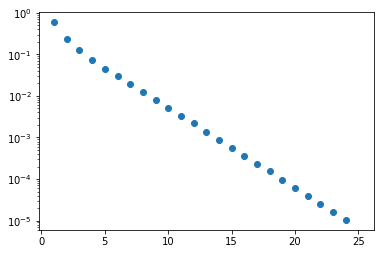

dim is 1, % energy is 80.959, and compression error is 0.0144316
dim is 2, % energy is 94.275, and compression error is 0.0079133
dim is 4, % energy is 99.178, and compression error is 0.0029981
dim is 8, % energy is 99.975, and compression error is 0.0005250
dim is 16, % energy is 100.000, and compression error is 0.0000153
dim is 32, % energy is 100.000, and compression error is 0.0000004
dim is 1, % energy is 80.959, and prediction error is 0.0146251
dim is 2, % energy is 94.275, and prediction error is 0.0080973
dim is 4, % energy is 99.178, and prediction error is 0.0030911
dim is 8, % energy is 99.975, and prediction error is 0.0005437
dim is 16, % energy is 100.000, and prediction error is 0.0000198
dim is 32, % energy is 100.000, and prediction error is 0.0005073


In [4]:
# Generate laminar flow data
generate_NSE_data(0.04, 2, [0.01], 1, 'laminar')
repo = np.load('laminar.npz')
snaps = repo['NSE_nu0']

rom = MyROM(0.04, 2)

rom.load_data_from_array(snaps, 400)
rom.generate_POD_basis()
rom.plot_evals(25)
rom.test_POD_projection()
rom.test_ROM_approximation(0.01, 400)

Reynolds number 214, P3/P2 elements.  Snapshots in [0,1] starting from rest.

velocity DOFs is 11466
POD basis of size 100 has been generated5


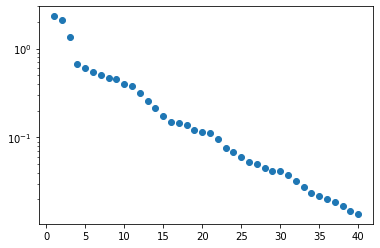

dim is 1, % energy is 38.317, and compression error is 0.1429087
dim is 2, % energy is 69.475, and compression error is 0.1005311
dim is 4, % energy is 85.585, and compression error is 0.0690847
dim is 8, % energy is 93.631, and compression error is 0.0459207
dim is 16, % energy is 99.138, and compression error is 0.0168972
dim is 32, % energy is 99.970, and compression error is 0.0031626
dim is 1, % energy is 38.317, and prediction error is 0.3009288
dim is 2, % energy is 69.475, and prediction error is 0.1874031
dim is 4, % energy is 85.585, and prediction error is 0.2366270
dim is 8, % energy is 93.631, and prediction error is 0.2242985
dim is 16, % energy is 99.138, and prediction error is 0.0537235
dim is 32, % energy is 99.970, and prediction error is 0.0053162


In [5]:
generate_NSE_data(0.04, 3, [5e-4, 6e-4, 7e-4], 1, 'periodic')
repo = np.load('periodic.npz')
snaps = repo['NSE_nu0']

rom = MyROM(0.04, 3)
rom.load_data_from_array(snaps, 400)
rom.generate_POD_basis()
rom.plot_evals(40)
rom.test_POD_projection()
rom.test_ROM_approximation(5e-4, 400)

Little animations which show the evolution of the first component of velocity. 
Top is FOM solution and bottom is ROM solution.

In [6]:
## Visualization for n=16
rom.assemble(16, 5e-4)
rom.integrate_fEuler(0.0025, 400, nSub=100)
uTilde = rom.reconstruct(rom.a)

gfut = GridFunction(rom.V, multidim=0)
for i,col in enumerate(snaps.T[::10]):
    gfut.AddMultiDimComponent(col[:11466])
Draw (gfut, rom.mesh, interpolate_multidim=True, animate=True)

gfut = GridFunction(rom.V, multidim=0)
for i,col in enumerate(uTilde.T[::10]):
    gfut.AddMultiDimComponent(col[:11466])
Draw (gfut, rom.mesh, interpolate_multidim=True, animate=True)

WebGuiWidget(value={'ngsolve_version': '6.2.2105', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

WebGuiWidget(value={'ngsolve_version': '6.2.2105', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

BaseWebGuiScene

Reynolds number 214, P3/P2 elements.  Snapshots in [0.5,1].

POD basis of size 100 has been generated


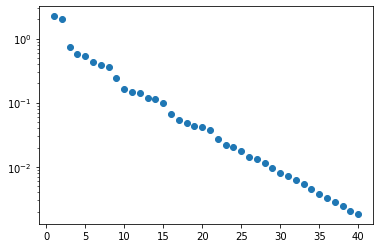

dim is 1, % energy is 46.022, and compression error is 0.1637235
dim is 2, % energy is 83.342, and compression error is 0.0909527
dim is 4, % energy is 91.505, and compression error is 0.0649525
dim is 8, % energy is 98.324, and compression error is 0.0288516
dim is 16, % energy is 99.880, and compression error is 0.0077262
dim is 32, % energy is 99.999, and compression error is 0.0006881
dim is 1, % energy is 46.022, and prediction error is 0.2299890
dim is 2, % energy is 83.342, and prediction error is 0.0986016
dim is 4, % energy is 91.505, and prediction error is 0.0768528
dim is 8, % energy is 98.324, and prediction error is 0.0431960
dim is 16, % energy is 99.880, and prediction error is 0.0097938
dim is 32, % energy is 99.999, and prediction error is 0.0011751


In [7]:
rom = MyROM(0.04, 3)
rom.load_data_from_array(snaps, 200)
rom.generate_POD_basis()
rom.plot_evals(40)
rom.test_POD_projection()
rom.test_ROM_approximation(5e-4, 200)

## Experiment from paper

Re 214, 155 for training, Re 180 for testing, P3/P2 elements.  

POD basis of size 100 has been generated


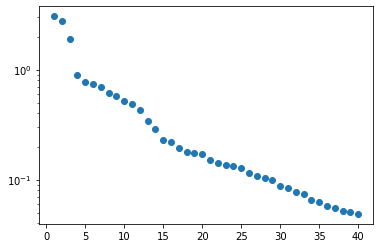

dim is 1, % energy is 37.049, and compression error is 0.1360920
dim is 2, % energy is 67.793, and compression error is 0.0966511
dim is 4, % energy is 85.452, and compression error is 0.0639926
dim is 8, % energy is 93.423, and compression error is 0.0418871
dim is 16, % energy is 98.667, and compression error is 0.0164824
dim is 32, % energy is 99.811, and compression error is 0.0063300
dim is 1, % energy is 37.049, and prediction error is 0.2937173
dim is 2, % energy is 67.793, and prediction error is 0.1764970
dim is 4, % energy is 85.452, and prediction error is 0.2230948
dim is 8, % energy is 93.423, and prediction error is 0.2020789
dim is 16, % energy is 98.667, and prediction error is 0.0295439
dim is 32, % energy is 99.811, and prediction error is 0.0143679


In [8]:
repo = np.load('periodic.npz')
snaps = np.concatenate((repo['NSE_nu0'], repo['NSE_nu2']), axis=1)

rom = MyROM(0.04, 3)
rom.load_data_from_array(snaps, 800)
rom.generate_POD_basis()
rom.plot_evals(40)

# Have to redefine some stuff for accurate testing
rom.u = repo['NSE_nu1']
rom.nSnaps = 400

rom.test_POD_projection()
rom.test_ROM_approximation(6e-4, 400)

Same little animations.  The trend is still well-captured.

In [9]:
## Visualization for n=16
rom.assemble(16, 6e-4)
rom.integrate_fEuler(0.0025, 400, nSub=100)
uTilde = rom.reconstruct(rom.a)

gfut = GridFunction(rom.V, multidim=0)
for i,col in enumerate(snaps.T[::10]):
    gfut.AddMultiDimComponent(col[:11466])
Draw (gfut, rom.mesh, interpolate_multidim=True, animate=True)

gfut = GridFunction(rom.V, multidim=0)
for i,col in enumerate(uTilde.T[::10]):
    gfut.AddMultiDimComponent(col[:11466])
Draw (gfut, rom.mesh, interpolate_multidim=True, animate=True)

WebGuiWidget(value={'ngsolve_version': '6.2.2105', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

WebGuiWidget(value={'ngsolve_version': '6.2.2105', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

BaseWebGuiScene